In [1]:
import os

from glob import glob
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt  
from PIL import Image
from pandarallel import pandarallel  

import json
import numpy as np
import cv2
import json

import torch.optim as optim
from dataset import CityScapeDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib as mpl  
# Initialize pandarallel  
pandarallel.initialize()
from helpers import *


/Users/m/dev/6be709c0/oc-ai-engineer/OC/P8/output/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## 1. Configuration

In [2]:
# Sample the dataset for training the model. 0 use the full dataset
SAMPLE_DATASET=3
NUM_EPOCHS=3
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 256

BATCH_SIZE = 16
NUM_WORKERS = 2
PIN_MEMORY = True
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"

LEARNING_RATE = 1e-4

## 2. Download data

The first step is to download the dataset if it's not already present

In [3]:
# Define file paths  
gtFine_path = './data/P8_Cityscapes_gtFine_trainvaltest.zip'  
leftImg8bit_path = './data/P8_Cityscapes_leftImg8bit_trainvaltest.zip'  
  
# Create the 'data' directory if it doesn't exist  
if not os.path.exists('data'):  
    os.makedirs('data')  
  
# Check and download the gtFine zip if it doesn't exist  
if not os.path.isfile(gtFine_path) and not os.path.isdir('./data/gtFine'):  
    !curl -L "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+8+-+Participez+%C3%A0+la+conception+d'une+voiture+autonome/P8_Cityscapes_gtFine_trainvaltest.zip" -o "{gtFine_path}"  
    print(f"Downloaded: {gtFine_path}")  
else:  
    print(f"File already exists, skipped downloading: {gtFine_path}")  
  
# Check and download the leftImg8bit zip if it doesn't exist  
if not os.path.isfile(leftImg8bit_path) and not os.path.isdir('./data/leftImg8bit'): 
    !curl -L "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+8+-+Participez+%C3%A0+la+conception+d'une+voiture+autonome/P8_Cityscapes_leftImg8bit_trainvaltest.zip" -o "{leftImg8bit_path}"  
    print(f"Downloaded: {leftImg8bit_path}")  
else:  
    print(f"File already exists, skipped downloading: {leftImg8bit_path}")  


File already exists, skipped downloading: ./data/P8_Cityscapes_gtFine_trainvaltest.zip
File already exists, skipped downloading: ./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip


In [4]:
# Unzip leftImg8bit
if os.path.isfile(gtFine_path):
    !unzip -q -n {gtFine_path} -d data/
    !rm {gtFine_path}
# Unzip leftImg8bit
if os.path.isfile(leftImg8bit_path):
    !unzip -q -n {leftImg8bit_path} -d data/
    !rm {leftImg8bit_path}

## 3. Data preparation and exploration

Looking at the data structure:

`gtFine` and `leftImg8bit` folders both have the folders:  
- test
- train
- val

Within each of this folder is another list of folders of specific city.

The `leftImg8bit` contains raw image about the city.  
The `gtFine` contains three 4 informations about each raw image:
- color.png
- instanceIds.png
- labelsIds.png
- polygons.json

The first thing I'm going to do is to create a dataframe that will combine all of this data to be processed easily.  
And I will have **three** dataframe. `Train`, `Val` and `Test`.

### 3.1 Images to dataframe

In [5]:
json_paths_train = glob('data/gtFine/train/**/*.json')
json_paths_test = glob('data/gtFine/test/**/*.json')
json_paths_val = glob('data/gtFine/val/**/*.json')

def get_file_info(json_path):
    file_path_prefix = json_path.replace("_polygons.json", "")
    
    original_img_path = (
        file_path_prefix
            .replace("gtFine/","leftImg8bit/")
            .replace("_gtFine", "_leftImg8bit.png")
    )
    
    color_img_path = file_path_prefix + "_color.png"
    instance_ids_img_path = file_path_prefix + "_instanceIds.png"
    label_ids_img_path = file_path_prefix + "_labelIds.png"
    polygons_json_path = json_path
    
    return [original_img_path, color_img_path, instance_ids_img_path, label_ids_img_path, polygons_json_path]

data_train = [get_file_info(path) for path in json_paths_train]
data_test = [get_file_info(path) for path in json_paths_test]
data_val = [get_file_info(path) for path in json_paths_val]

columns = ["original_img_path", "color_img_path", "instance_ids_img_path", "label_ids_img_path", "polygons_json_path"]
df_train = pd.DataFrame(data_train, columns=columns)
df_test = pd.DataFrame(data_test, columns=columns)
df_val = pd.DataFrame(data_val, columns=columns)

In [6]:
df_train.head()

,original_img_path,color_img_path,instance_ids_img_path,label_ids_img_path,polygons_json_path
0,data/leftImg8bit/train/zurich/zurich_000101_00...,data/gtFine/train/zurich/zurich_000101_000019_...,data/gtFine/train/zurich/zurich_000101_000019_...,data/gtFine/train/zurich/zurich_000101_000019_...,data/gtFine/train/zurich/zurich_000101_000019_...
1,data/leftImg8bit/train/zurich/zurich_000098_00...,data/gtFine/train/zurich/zurich_000098_000019_...,data/gtFine/train/zurich/zurich_000098_000019_...,data/gtFine/train/zurich/zurich_000098_000019_...,data/gtFine/train/zurich/zurich_000098_000019_...
2,data/leftImg8bit/train/zurich/zurich_000078_00...,data/gtFine/train/zurich/zurich_000078_000019_...,data/gtFine/train/zurich/zurich_000078_000019_...,data/gtFine/train/zurich/zurich_000078_000019_...,data/gtFine/train/zurich/zurich_000078_000019_...
3,data/leftImg8bit/train/zurich/zurich_000016_00...,data/gtFine/train/zurich/zurich_000016_000019_...,data/gtFine/train/zurich/zurich_000016_000019_...,data/gtFine/train/zurich/zurich_000016_000019_...,data/gtFine/train/zurich/zurich_000016_000019_...
4,data/leftImg8bit/train/zurich/zurich_000051_00...,data/gtFine/train/zurich/zurich_000051_000019_...,data/gtFine/train/zurich/zurich_000051_000019_...,data/gtFine/train/zurich/zurich_000051_000019_...,data/gtFine/train/zurich/zurich_000051_000019_...


Before processing the dataset, I'm adding an option to sample it

In [7]:
if SAMPLE_DATASET > 0:
    print(f"Sampling the dataset to {SAMPLE_DATASET}.")
    df_train = df_train.sample(n=SAMPLE_DATASET, random_state=42).reset_index(drop=True)
    df_test = df_test.sample(n=SAMPLE_DATASET, random_state=42).reset_index(drop=True)
    df_val = df_val.sample(n=SAMPLE_DATASET, random_state=42).reset_index(drop=True)
else:
    print("Using the full dataset")

Sampling the dataset to 3.


### 3.2 What data do I need ?

I have multiple files that can be used to train my model.  
I'm not sure which one do I need.

Let's have a look at them first.

In [8]:
def display_images(row):  
    # Get the paths of the images from the DataFrame  
    original_img_path = row['original_img_path']  
    color_img_path = row['color_img_path']  
    instance_ids_img_path = row['instance_ids_img_path']  
    label_ids_img_path = row['label_ids_img_path']  
  
    # Open the images using PIL  
    original_img = Image.open(original_img_path)  
    color_img = Image.open(color_img_path)  
    instance_ids_img = Image.open(instance_ids_img_path)  
    label_ids_img = Image.open(label_ids_img_path)  
  
    # Create a figure with subplots  
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))  
  
    # Display the images in the subplots  
    ax[0].imshow(original_img)  
    ax[0].set_title('Original Image')  
    ax[0].axis('off')  
  
    ax[1].imshow(color_img)  
    ax[1].set_title('Color Image')  
    ax[1].axis('off')  
  
    ax[2].imshow(instance_ids_img)  
    ax[2].set_title('Instance IDs Image')  
    ax[2].axis('off')  
  
    ax[3].imshow(label_ids_img)  
    ax[3].set_title('Label IDs Image')  
    ax[3].axis('off')  
  
    plt.show()  

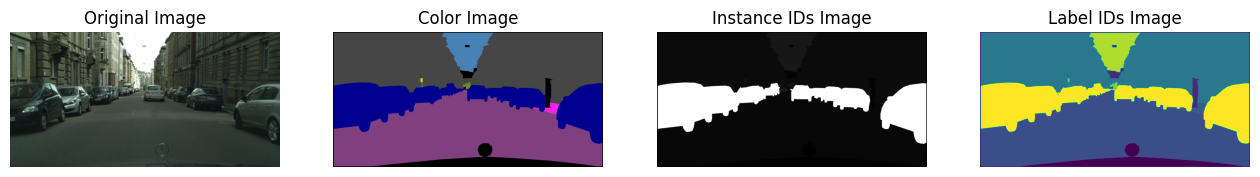

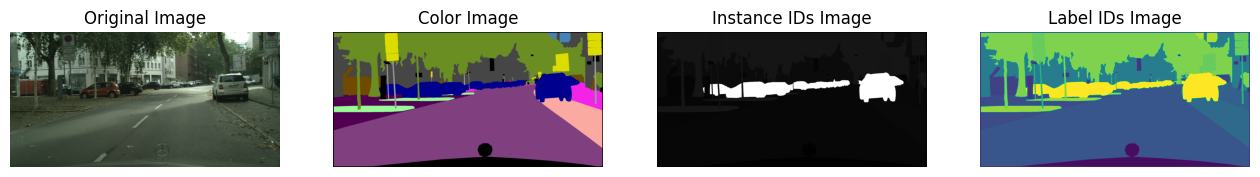

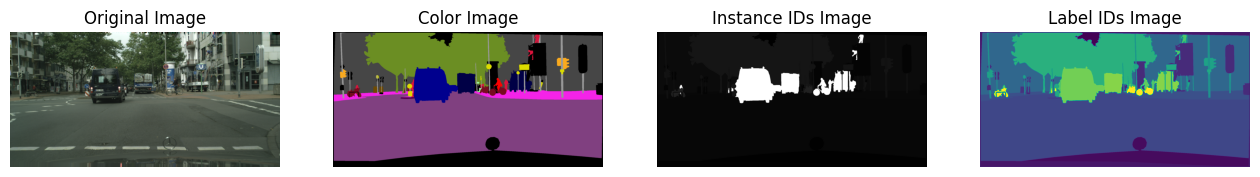

In [9]:
display_images(df_train.loc[0])  
display_images(df_train.loc[1])  
display_images(df_train.loc[2])  

From that result, I will definitely use the original image.  
- The `color image` seems to have all the values as well as the `label ids image`
- The `instance ids image` seems to do it too using very similar shade of black and white. Making it difficult for our eyes to see the difference.

To be honest, the requirements is to train on only 8 categories and not the 32 sub categories.  
Here I have all of them but I don't know which one is which.

This is where the polygons_json_path seems interesting because it has all the labels and the polygons defined.  
I'm more confortable and confident to start using this approach. I know which labels correspond to what and I can use the polygons as the mask.

### 3.3 Polygons processing

To validate this approach, I am going to create the mask out of the polygons and see if it's correct.  
So I'm also going to map the subcategories to the 8 ones.

What are all the labels available in my polygons?

25 labels found


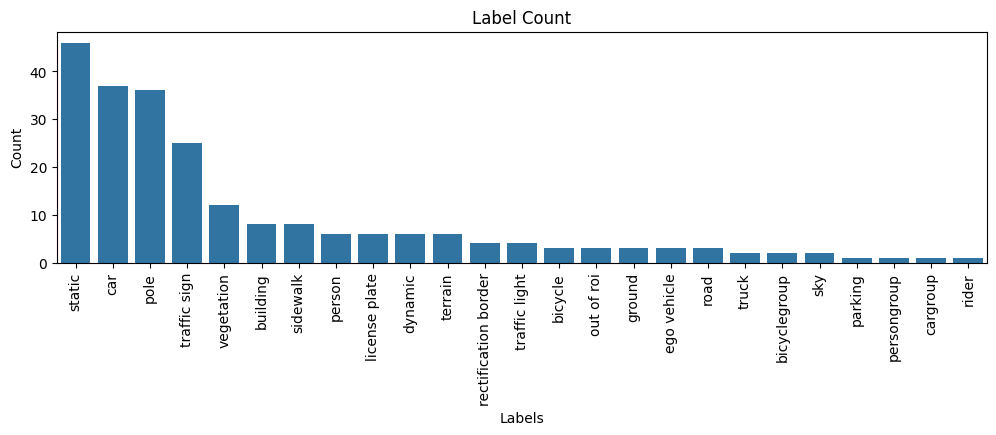

In [10]:
def polygon_labels(json_path):  
    # Load the JSON File 
    label_count = {}
    json_data = json.load(open(json_path))
    for obj in json_data['objects']:    
        label = obj['label']  
          
        # Check if label already exists in dictionary  
        if label in label_count:  
            label_count[label] += 1  # Increment count if label exists  
        else:  
            label_count[label] = 1  # Add new label to dictionary  
      
    return label_count

# Initialize dictionary to store label count
label_counts = df_train["polygons_json_path"].parallel_apply(polygon_labels)

# Combine all dictionaries  
combined_label_counts = {}  
for label_count in label_counts:  
    for label, count in label_count.items():  
        if label in combined_label_counts:  
            combined_label_counts[label] += count  
        else:  
            combined_label_counts[label] = count  
  
# Convert dictionary to a pandas DataFrame  
df_label_count = pd.DataFrame.from_dict(combined_label_counts, orient='index', columns=['count'])  
df_label_count = df_label_count.reset_index().rename(columns={'index': 'label'})  
  
# Sort the DataFrame by count in descending order  
df_label_count = df_label_count.sort_values('count', ascending=False)  

print(f"{len(combined_label_counts)} labels found")
  
# Plot the label count using seaborn  
plt.figure(figsize=(12, 3))
sns.barplot(x='label', y='count', data=df_label_count)  
plt.title("Label Count")  
plt.xlabel("Labels")  
plt.ylabel("Count")  
plt.xticks(rotation=90)  
plt.show()


Even better, 40 categories out of 32 expected, meaning I can be more flexible if needed.

From the dataset documentation:

> * Single instance annotations are available. However, if the boundary between such instances cannot be clearly seen, the whole crowd/group is labeled together and annotated as group, e.g. car group.
> + This label is not included in any evaluation and treated as void (or in the case of license plate as the vehicle mounted on).

Now let's do the mapping

In [11]:

def display_images_with_mask(row):  
    # Get the paths of the images from the DataFrame  
    original_img_path = row['original_img_path']  
    color_img_path = row['color_img_path']  
    label_ids_img_path = row['label_ids_img_path']
    # Open the images using PIL  
    original_img = Image.open(original_img_path)  
    color_img = Image.open(color_img_path)  
    mask_img = polygon_to_mask_img(row["polygons_json_path"])
    label_ids_img = Image.open(label_ids_img_path)  
  
    # Create a figure with subplots  
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))  
  
    # Display the images in the subplots  
    ax[0].imshow(original_img)  
    ax[0].set_title('Original Image')  
    ax[0].axis('off')  
  
    ax[1].imshow(mask_img)  
    ax[1].set_title('Mask Image (8 cat)')  
    ax[1].axis('off')  
    
    ax[2].imshow(color_img)  
    ax[2].set_title('Color Image (32 cat)')  
    ax[2].axis('off')  
  
    ax[3].imshow(label_ids_img)  
    ax[3].set_title('Label IDs Image (32 cat)')  
    ax[3].axis('off')  
  
    plt.show()
    
    
def display_image_with_mask(row):
    
    original = Image.open(row['original_img_path']).convert("RGBA")  
    
    mask_img_array = polygon_to_mask_img(row["polygons_json_path"])
    color_map = plt.cm.get_cmap('viridis', 8)
    
    mask_img = color_map(mask_img_array)
    # mask_img = Image.fromarray(mask_img_array).convert("RGB")
    
    mask_with_opacity = mask_img.copy()
    overlay_with_opacity = mask_with_opacity.putalpha(int(255 * 0.5))
    
    blended_image = Image.alpha_composite(original, mask_with_opacity)  

    # Create a figure with subplots  
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))  
  
    # Display the images in the subplots  
    ax[0].imshow(original)  
    ax[0].set_title('Original Image')  
    ax[0].axis('off')  
  

    ax[1].imshow(mask_img)  
    ax[1].set_title('Mask Image')  
    ax[1].axis('off')  
    
    ax[2].imshow(blended_image)  
    ax[2].set_title('Original + Mask')  
    ax[2].axis('off')
    plt.show()  

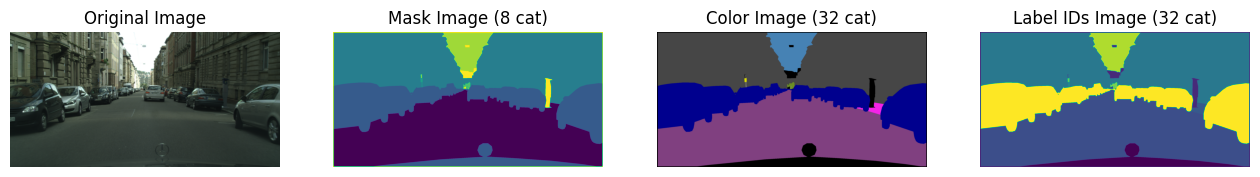

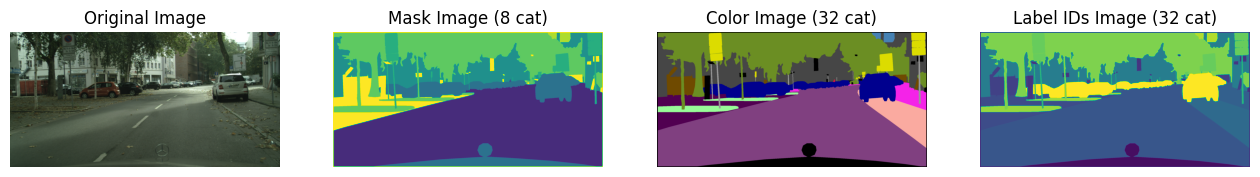

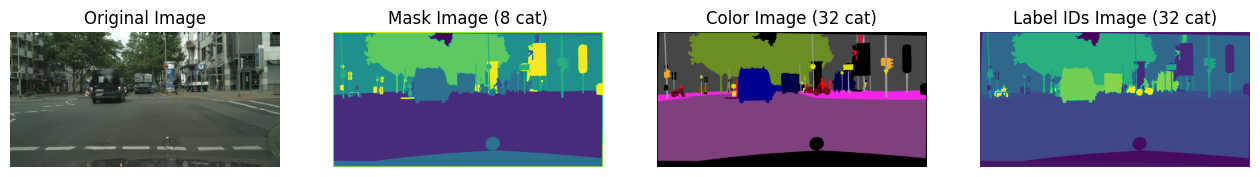

In [12]:
display_images_with_mask(df_train.loc[0])  
display_images_with_mask(df_train.loc[1])  
display_images_with_mask(df_train.loc[2]) 

Great! Checking on three images, the polygon mask created captures all the informations needed, and now we can define what it correspond to.
Let's put the mask on top of the original image:

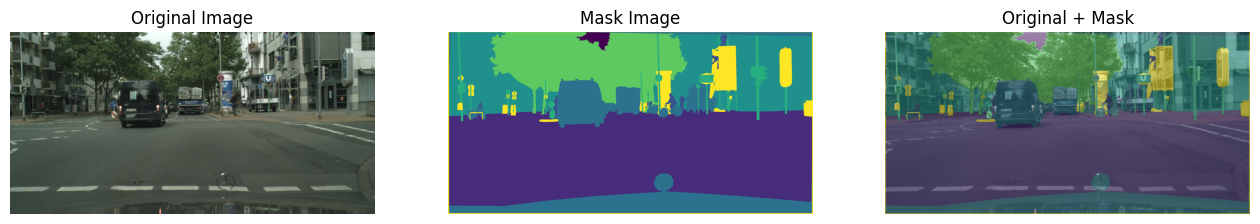

In [13]:


def display_image_with_mask(row):  
      
    original = Image.open(row['original_img_path']).convert("RGBA")  
      
    # Assuming polygon_to_mask_img returns a 2D array (mask)  
    mask_img_array = polygon_to_mask_img(row["polygons_json_path"])  
      
    # Apply colormap to mask and normalize the mask image array to be within the range [0, 1]  
    # before applying the colormap. Then, convert colormap output to uint8 (since colormap returns floats).  
    color_map = mpl.colormaps.get_cmap('viridis')  
        
    mask_img_array_normalized = mask_img_array / mask_img_array.max()  
    mask_img_colored = color_map(mask_img_array_normalized)  
    mask_img_colored = (mask_img_colored * 255).astype(np.uint8)  
      
    # Convert the RGBA numpy array to a PIL Image  
    mask_img = Image.fromarray(mask_img_colored, 'RGBA')  
      
    # Create a copy of the mask image to change its alpha.  
    # The putalpha method does not return a value; it modifies the image in place.  
    mask_with_opacity = mask_img.copy()  
    mask_with_opacity.putalpha(int(255 * 0.5))  
      
    # Ensure both original and mask_with_opacity images are in "RGBA" mode and have the same dimensions.  
    if original.size != mask_with_opacity.size:  
        mask_with_opacity = mask_with_opacity.resize(original.size)  
      
    blended_image = Image.alpha_composite(original, mask_with_opacity)  
      
    # Create a figure with subplots  
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))  
      
    # Display the images in the subplots  
    ax[0].imshow(original)  
    ax[0].set_title('Original Image')  
    ax[0].axis('off')  
      
    ax[1].imshow(mask_img)  
    ax[1].set_title('Mask Image')  
    ax[1].axis('off')  
      
    ax[2].imshow(blended_image)  
    ax[2].set_title('Original + Mask')  
    ax[2].axis('off')  
      
    plt.show()  
    
    
display_image_with_mask(df_train.loc[2])

In [14]:
t = plt.cm.get_cmap('viridis', 8)


/var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/ipykernel_4028/3976594022.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  t = plt.cm.get_cmap('viridis', 8)


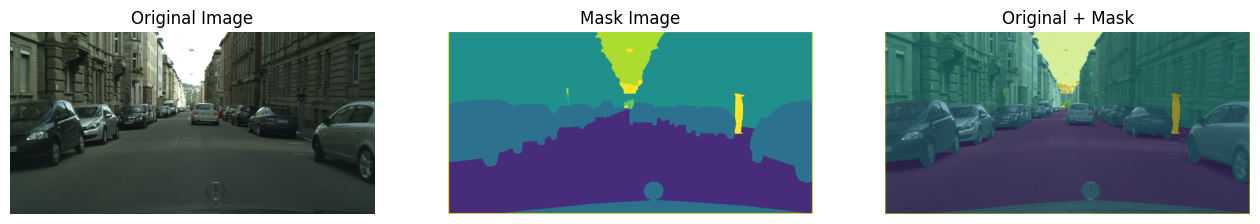

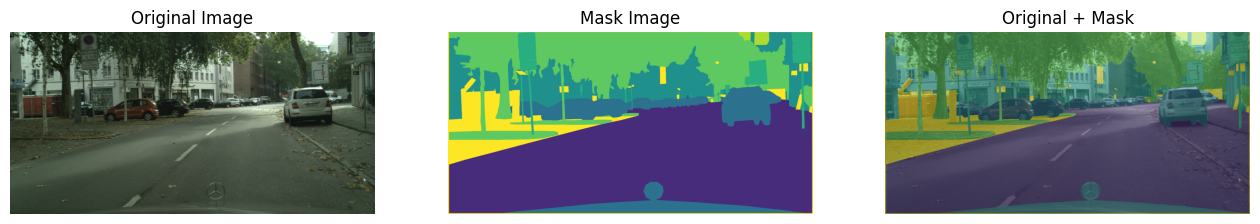

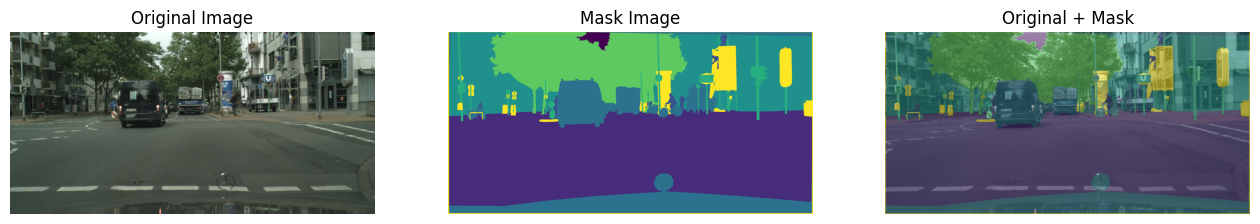

In [15]:
display_image_with_mask(df_train.loc[0])
display_image_with_mask(df_train.loc[1])
display_image_with_mask(df_train.loc[2])

It looks great!

### 3.4 Image & Categories exploration

Let's quickly check if all images have the same width and height.  
Then we will see the distribution per category.

In [16]:
# Combining all dataframe for exploration
df_all = pd.concat([df_train, df_val, df_test]).reset_index(drop=True)
print(df_all.shape)

(9, 5)


In [17]:
def get_image_size(image_path):  
    image = cv2.imread(image_path)  
    return f"{image.shape[1]}x{image.shape[0]}"  
  
def get_polygon_size(json_path):  
    json_data = json.load(open(json_path))
    return f"{json_data['imgWidth']}x{json_data['imgHeight']}"

def count_categories_in_polygon(json_path):
    categories = ["flat","human","vehicle","construction","object","nature", "sky", "void"]
    category_counts = {f"c_{k}": 0 for k in categories}  # Initialize counts  
    try: 
        data = json.load(open(json_path))
        for obj in data['objects']:
            label = obj['label']
            category = category_mapping.get(label)  # Map label to category  
            if category is not None:  
                category_counts[f"c_{categories[category-1]}"] += 1  # Increment count  
    except json.JSONDecodeError:  
        print("Error decoding JSON")  
    return category_counts  
 

In [18]:
# Apply the function to the "original_img_path" column  
df_all["img_size"] = df_all["original_img_path"].parallel_apply(get_image_size) 
df_all["mask_size"] = df_all["polygons_json_path"].parallel_apply(get_polygon_size)

In [19]:
print("Img unique size:", df_all["img_size"].nunique(), "=", df_all.loc[0]["img_size"])
print("Mask unique size:", df_all["mask_size"].nunique(), "=", df_all.loc[0]["mask_size"])

Img unique size: 1 = 2048x1024
Mask unique size: 1 = 2048x1024


All good, they all have the same size accross val, test, and train.  
Let's now check the category distribution

In [20]:
# Count category by image
counts_df = df_all['polygons_json_path'].parallel_apply(lambda x: count_categories_in_polygon(x))
counts_df = counts_df.parallel_apply(pd.Series)
df_all = pd.concat([df_all, counts_df], axis=1) 

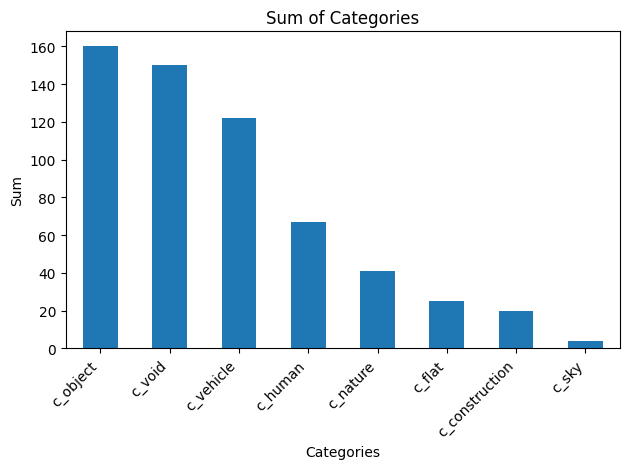

In [21]:
# Summing up the specified columns  
totals = df_all[["c_flat", "c_human", "c_vehicle",  
                        "c_construction", "c_object", "c_nature",   
                        "c_sky", "c_void"]].sum()
# Sorting totals from high to low  
totals = totals.sort_values(ascending=False)  
# Plotting  
totals.plot(kind='bar')  
plt.title('Sum of Categories')  
plt.xlabel('Categories')  
plt.ylabel('Sum')  
plt.xticks(rotation=45, ha="right")
plt.tight_layout() 
plt.show()

Good to know, object are the most present, folloed by vehicle and void.  
Sky being the smallest.

Let's create the models!

## 4. Model development

We are going to test multiple models:

- **unet_mini**: a smaller version of unet, our baseline
- **unet**: todo
- **unet with VGG16**: todo
- **segformer**: todo
- **huggingface latest models**: todo

In order to check their performance, we will use different metrics:

- **dice** todo
- **IoU** todo
- **time** todo
- **todo** todo

### 4.1 Shared functions

### 4.2 Unet MINI

**What is it ?**

Lorem ipsum

|    **Pro**    |    **Cons**   |
|---------------|---------------|
|     todo      |     todo      |
|     todo      |     todo      |

In [22]:
train_transform = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0
        ),
        ToTensorV2(),
    ])

val_transforms = A.Compose([
        A.Resize(height=IMAGE_HEIGHT,width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0
        ),
        ToTensorV2(),
    ])

In [23]:
train_ds = CityScapeDataset(
    dataframe=df_train, 
    transform=train_transform
)
val_ds = CityScapeDataset(
    dataframe=df_val, 
    transform=val_transforms
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False
)
    

In [24]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1 ,1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, 3, 1 ,1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)
    
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                     feature*2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
            
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
    def forward(self, x):
        skip_connections = []
        for down in self.downs:
                x = down(x)
                skip_connections.append(x)
                x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
                
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        
        return self.final_conv(x)

In [25]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    model.train()
    
    for batch_idx, (data, targets) in enumerate(loop):
        
        data = data.to(device=DEVICE)
        targets = targets.long().to(device=DEVICE)  # Ensure targets are LongTensor  
        
          

        with torch.cuda.amp.autocast():  # Use mixed precision context  
            predictions = model(data)  
            loss = loss_fn(predictions, targets)          
            
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())
    

In [26]:
model = UNET(in_channels=3, out_channels=8).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

/Users/m/dev/6be709c0/oc-ai-engineer/OC/P8/output/venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [27]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)
    
for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model,optimizer, loss_fn, scaler)        
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    
    save_checkpoint(checkpoint)
    # check acccuracy
    check_accuracy(val_loader, model, device=DEVICE)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/m/dev/6be709c0/oc-ai-engineer/OC/P8/output/venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 1/1 [00:08<00:00,  8.11s/it, loss=2.11]


=> Saving checkpoint
Got 121011/786432 with acc 15.39
dice_score 0.6685433983802795


100%|██████████| 1/1 [00:07<00:00,  7.67s/it, loss=2]


=> Saving checkpoint
Got 121011/786432 with acc 15.39
dice_score 0.6685433983802795


100%|██████████| 1/1 [00:07<00:00,  7.72s/it, loss=1.92]


=> Saving checkpoint
Got 121011/786432 with acc 15.39
dice_score 0.6685433983802795


In [28]:
check_accuracy(val_loader, model, device=DEVICE)

Got 121011/786432 with acc 15.39
dice_score 0.6685433983802795


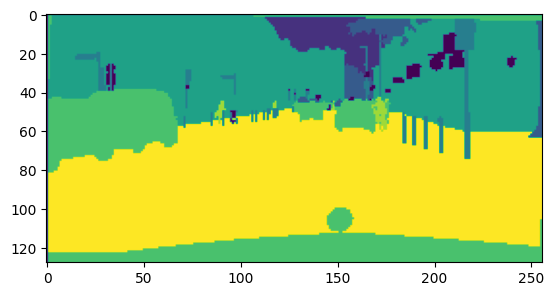

In [29]:
# Display the image  
img = Image.open("./mask.png")  
img_arr = np.array(img)  

plt.imshow(img_arr, cmap='viridis')  

In [30]:
import torchvision.transforms as T  

def load_and_preprocess_image(img_path, mask_img_array, transform):  
        img = Image.open(img_path).convert("RGB")
        image_np = np.array(img)

        mask =  Image.fromarray(mask_img_array).convert("RGBA")
        mask_np = np.array(mask.convert("L"), dtype=np.float32)

        augmentations = transform(image=image_np, mask=mask_np)
        image_np = augmentations["image"]
        mask_np = augmentations["mask"]

        return image_np, mask_np

def predict(model, image_tensor, device="mps"):
    model.to(device)
    model.eval()  # Set model to evaluation mode  
    with torch.no_grad():  
        image_tensor = image_tensor.to(device)  
        output = model(image_tensor)  
        predictions = output.argmax(dim=1).cpu().squeeze(0)  # Remove batch dim and take argmax  
    return predictions  

In [31]:

def display_pred_image(row, predicted_mask_data):    
    original = Image.open(row['original_img_path']).convert("RGBA")    
    
    # ORIGINAL MASK
    mask_img_array = polygon_to_mask_img(row["polygons_json_path"])
    color_map = mpl.colormaps.get_cmap('viridis')    
    
    mask_img_array_normalized = mask_img_array / mask_img_array.max()  
    mask_img_colored = color_map(mask_img_array_normalized)  
    mask_img_colored = (mask_img_colored * 255).astype(np.uint8)  
    mask_img = Image.fromarray(mask_img_colored, 'RGBA') 

    # PREDICTED MASK
    # Convert predicted mask back to NumPy for easier manipulation  
    # predicted_mask = predicted_mask_data.squeeze().cpu().detach().numpy()  
    # predicted_mask_normalized = predicted_mask / predicted_mask.max()  
    # predicted_mask_colored = color_map(predicted_mask_normalized)  
    # predicted_mask_colored = (predicted_mask_colored * 255).astype(np.uint8)  
    # predicted_mask_img = Image.fromarray(predicted_mask_colored, 'RGBA')  
      
    # # Apply half opacity to the predicted mask for overlay visualization  
    # predicted_mask_with_opacity = predicted_mask_img.copy()  
    # predicted_mask_with_opacity.putalpha(int(255 * 0.5))  
      
    # # Resize if necessary to ensure dimensions match for alpha_composite  
    # if original.size != predicted_mask_with_opacity.size:    
    #     predicted_mask_with_opacity = predicted_mask_with_opacity.resize(original.size)    
      
    # blended_image = Image.alpha_composite(original, predicted_mask_with_opacity)     
      
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))    
      
    ax[0].imshow(original)    
    ax[0].set_title('Original Image')    
    ax[0].axis('off')    
      
    ax[1].imshow(mask_img)    
    ax[1].set_title('Original Mask')    
    ax[1].axis('off')    
    
    ax[2].imshow(predicted_mask)  
    ax[2].set_title('Predicted Mask')  
    ax[2].axis('off')  
      
    # ax[3].imshow(blended_image)    
    # ax[3].set_title('Original + Pred Mask')    
    # ax[3].axis('off')    
      
    plt.show()  
   
    
def check_one(model, row, device="mps"):  
    model.to(device)
    model.eval()
    
    color_map = mpl.colormaps.get_cmap('viridis')    
    mask_img_array = polygon_to_mask_img(row["polygons_json_path"])

    image_tensor, mask_tensor = load_and_preprocess_image(row["original_img_path"],mask_img_array, val_transforms)  # Assuming this uses the defined val_transforms  
    
    image_tensor = image_tensor.unsqueeze(0).to(device)
    mask_tensor = mask_tensor.to(device)
    
    with torch.no_grad():  # It's good practice to use no_grad for evaluation  
        predicted_mask_data = model(image_tensor)  
    
     # Apply softmax and argmax to get class predictions  
    predictions = torch.argmax(torch.softmax(predicted_mask_data, dim=1), dim=1)
    
    # Assuming mask_tensor is already in the correct shape and format for comparison  
    num_correct = (predictions == mask_tensor).sum().item()    
    num_pixels = torch.numel(predictions)    
      
    dice_score = (2 * (predictions == mask_tensor).float().sum()) / (  
        predictions.float().sum() + mask_tensor.float().sum() + 1e-8    
    )  
        
    accuracy = num_correct / num_pixels * 100    
    print(f"Pixel Accuracy: {accuracy:.2f}%")    
    print(f"Dice Score: {dice_score.item()}") 
    
    predicted_mask = torch.argmax(predicted_mask_data, dim=1)  # This operation converts it from [1, C, H, W] to [1, H, W]  
    predicted_mask = predicted_mask.squeeze().cpu().numpy()  # Convert it to a numpy array for visualization [H, W]  
    
    # Mapping class indexes to colors using the color map and plotting  
    plt.imshow(color_map(predicted_mask / np.max(predicted_mask)))  # Normalize values between 0 and 1  
    plt.title("Predicted Mask")  
    plt.axis('off')  # Hide axis for better visualization  
    plt.show()
    
    # Display the predicted mask alongside the original mask for visual comparison   
    # display_pred_image(row, mask_img_array, predicted_mask.cpu().numpy())  
    # display_pred_image(row, predicted_mask_data)  
    return predicted_mask

  

Pixel Accuracy: 36.98%
Dice Score: 0.18588916957378387


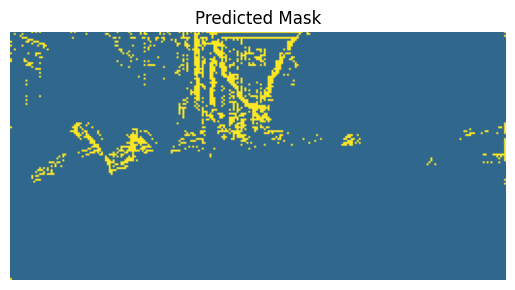

In [34]:
# Load and preprocess the image
model.eval()
pred = check_one(model, df_train.loc[0], "mps")